In [1]:
from io import StringIO

import pdfminer
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Perform layout analysis for all text
laparams = pdfminer.layout.LAParams()
setattr(laparams, 'all_texts', True)

def convert_pdf_to_text(file_path):
        
    output_string = StringIO()
    
    with open(file_path, 'rb') as in_file:
        parser = PDFParser(in_file)
        doc = PDFDocument(parser)
        rsrcmgr = PDFResourceManager()
        device = TextConverter(rsrcmgr, output_string, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)
        for page in PDFPage.create_pages(doc):
            interpreter.process_page(page)

    return output_string.getvalue()

In [2]:
import glob
from tqdm import tqdm

# years 2013 - 2021

file_names_train = glob.glob("src\\*.pdf")
file_names_train[:5]

['src\\1.pdf', 'src\\10.pdf', 'src\\11.pdf', 'src\\12.pdf', 'src\\13.pdf']

In [3]:
# year 2022

file_names_test = glob.glob("src\\2022\\*.pdf")
file_names_test[:5]

['src\\2022\\1.pdf',
 'src\\2022\\10.pdf',
 'src\\2022\\11.pdf',
 'src\\2022\\13.pdf',
 'src\\2022\\14.pdf']

In [4]:
raw_text_extract_train_list = [convert_pdf_to_text(file_name) for file_name in tqdm(file_names_train)]

100%|██████████| 96/96 [08:16<00:00,  5.17s/it]


In [5]:
raw_text_extract_test_list = [convert_pdf_to_text(file_name) for file_name in tqdm(file_names_test)]

100%|██████████| 24/24 [02:09<00:00,  5.41s/it]


In [6]:
import pandas as pd
import numpy as np

# extract the timestamps of all publications

df_timestamp = pd.read_csv("papers_timestamp.csv")
df_timestamp

,File_name,Timestamp
0,src\1.pdf,Apr-16
1,src\10.pdf,Nov-17
2,src\11.pdf,Jan-20
3,src\12.pdf,Aug-20
4,src\13.pdf,Aug-18
...,...,...
91,src\92.pdf,May-13
92,src\93.pdf,Mar-13
93,src\94.pdf,Feb-13
94,src\95.pdf,Aug-17


In [7]:
df_timestamp_2022 = pd.read_csv("papers_timestamp_2022.csv")
df_timestamp_2022

,File_name,Timestamp
0,src\2022\1.pdf,Mar-22
1,src\2022\10.pdf,Oct-22
2,src\2022\11.pdf,Nov-22
3,src\2022\13.pdf,Oct-22
4,src\2022\14.pdf,Dec-22
5,src\2022\16.pdf,Dec-22
6,src\2022\17.pdf,Sep-22
7,src\2022\18.pdf,Mar-22
8,src\2022\19.pdf,Dec-22
9,src\2022\20.pdf,Apr-22


In [8]:
pd.reset_option('all')

In [9]:
additional_stopwords = [
    "university",
    "acm",
    "copyright",
    "ieee",
    "research",
    "conference",
    "workshop",
    "international",
    "journal",
    "proceedings",
    "paper",
    "software",
    "traceability",
    "trace",
    "link",
    "introduction",
    "literature",
    "method",
    "methodology",
    "result",
    "conclusion",
    "discussion",
    "fig",
    "figure",
    "acknowledgement",
    "section"
]

In [10]:
def remove_text_before_abstract(text):
    
    text = " ".join(text)
    
    if "abstract" in text:
        text_list = text.split("abstract")
    elif "a b s t r a c t" in text:
        text_list = text.split("a b s t r a c t")
    else:
        text_list = ["",text]
    
    return text_list[1]

In [11]:
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# from gensim.utils import lemmatize
nltk.download('stopwords')
nltk.download('punkt')

stemmer = SnowballStemmer(language='english')

nlp = spacy.load('en_core_web_lg')

s_words = stopwords.words()

def run_text_processing_stemmed(text):
    text = text.replace("\n"," ") # remove new line characters
    text = text.replace("cid"," ") # remove cid characters relating to non-unicode characters
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text) # keep only alphanumeric
    text = re.sub(' +', ' ', text) # remove multiple whitespaces
    text = text.lower() # convert all to lowercase
    
    text_tokens = word_tokenize(text) # tokenise text
    text_tokens = [word for word in text_tokens if not word in s_words] # remove stopwords
    text_tokens = [word for word in text_tokens if not word in additional_stopwords] # remove additional stopwords
    text_tokens = [word for word in text_tokens if (len(word) > 2 and not word.isdecimal())] # remove anything with 2 chars and below

    text_tokens = [word.lemma_ for word in nlp(" ".join(text_tokens))]
    
    text_tokens = remove_text_before_abstract(text_tokens)
    
    text_tokens = word_tokenize(text_tokens)

    text_tokens_stem = [stemmer.stem(word) for word in text_tokens]

    return " ".join(text_tokens_stem)

def run_text_processing(text):
    text = text.replace("\n"," ") # remove new line characters
    text = text.replace("cid"," ") # remove cid characters relating to non-unicode characters
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text) # keep only alphanumeric
    text = re.sub(' +', ' ', text) # remove multiple whitespaces
    text = text.lower() # convert all to lowercase
    
    text_tokens = word_tokenize(text) # tokenise text
    text_tokens = [word for word in text_tokens if not word in s_words] # remove stopwords
    text_tokens = [word for word in text_tokens if not word in additional_stopwords] # remove additional stopwords
    text_tokens = [word for word in text_tokens if (len(word) > 2 and not word.isdecimal())] # remove anything with 2 chars and below
    
    text_tokens = [word.lemma_ for word in nlp(" ".join(text_tokens))]
    text_tokens = remove_text_before_abstract(text_tokens)
    
    return text_tokens

def run_text_processing_2(text):
    text = text.replace("\n"," ") # remove new line characters
    text = text.replace("cid"," ") # remove cid characters relating to non-unicode characters
    text = re.sub(r'[^a-zA-Z0-9 ]', ' ', text) # keep only alphanumeric
    text = re.sub(' +', ' ', text) # remove multiple whitespaces
    text = text.lower() # convert all to lowercase
    
    text_tokens = word_tokenize(text) # tokenise text
    text_tokens = [word for word in text_tokens if not word in s_words] # remove stopwords
    text_tokens = [word for word in text_tokens if not word in additional_stopwords] # remove additional stopwords
    text_tokens = [word for word in text_tokens if (len(word) > 2 and not word.isdecimal())] # remove anything with 2 chars and below
    
    text_tokens = " ".join(text_tokens)
    text_tokens = [word.decode('utf-8').split('/')[0] for word in lemmatize(text_tokens)]
    text_tokens = remove_text_before_abstract(text_tokens)
    
    return text_tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biadge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biadge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
clean_text_extract_train_list = [run_text_processing(x) for x in tqdm(raw_text_extract_train_list)]
# clean_text_extract_train_list_stemmed = [run_text_processing_stemmed(x) for x in tqdm(raw_text_extract_train_list)]

100%|██████████| 96/96 [04:43<00:00,  2.95s/it]


In [13]:
clean_text_extract_test_list = [run_text_processing(x) for x in tqdm(raw_text_extract_test_list)]
# clean_text_extract_test_list_stemmed = [run_text_processing_stemmed(x) for x in tqdm(raw_text_extract_test_list)]

100%|██████████| 24/24 [01:22<00:00,  3.42s/it]


In [14]:
# pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', None)

df_train = pd.DataFrame(np.transpose([file_names_train, clean_text_extract_train_list]), columns=['File_name', 'Text_extract'])
df_train = df_train.merge(df_timestamp, on='File_name')
df_train

,File_name,Text_extract,Timestamp
0,src\1.pdf,major problem development process manage arte...,Apr-16
1,src\10.pdf,recover link artifact requirement common task...,Nov-17
2,src\11.pdf,development devops practice widely approach c...,Jan-20
3,src\12.pdf,matter engineering community long time proces...,Aug-20
4,src\13.pdf,aim address problem incompleteness inconsiste...,Aug-18
...,...,...,...
91,src\92.pdf,large development project receive bug report ...,May-13
92,src\93.pdf,completely analyze closed issue report develo...,Mar-13
93,src\94.pdf,credit permit copy republish post server redi...,Feb-13
94,src\95.pdf,case drive modularization improve code compre...,Aug-17


In [15]:
file_names_test

['src\\2022\\1.pdf',
 'src\\2022\\10.pdf',
 'src\\2022\\11.pdf',
 'src\\2022\\13.pdf',
 'src\\2022\\14.pdf',
 'src\\2022\\16.pdf',
 'src\\2022\\17.pdf',
 'src\\2022\\18.pdf',
 'src\\2022\\19.pdf',
 'src\\2022\\20.pdf',
 'src\\2022\\21.pdf',
 'src\\2022\\22.pdf',
 'src\\2022\\23.pdf',
 'src\\2022\\24.pdf',
 'src\\2022\\25.pdf',
 'src\\2022\\27.pdf',
 'src\\2022\\28.pdf',
 'src\\2022\\29.pdf',
 'src\\2022\\3.pdf',
 'src\\2022\\30.pdf',
 'src\\2022\\31.pdf',
 'src\\2022\\4.pdf',
 'src\\2022\\5.pdf',
 'src\\2022\\6.pdf']

In [16]:
# pd.set_option('display.max_columns', None)
# pd.set_option('max_colwidth', None)

df_test = pd.DataFrame(np.transpose([file_names_test, clean_text_extract_test_list]), columns=['File_name', 'Text_extract'])
df_test = df_test.merge(df_timestamp_2022, on='File_name')
df_test

,File_name,Text_extract,Timestamp
0,src\2022\1.pdf,development prove importance domain change ma...,Mar-22
1,src\2022\10.pdf,approve link artifact base artifact relate sy...,Oct-22
2,src\2022\11.pdf,feature location map high,Nov-22
3,src\2022\13.pdf,evaluation play key role assess formance appr...,Oct-22
4,src\2022\14.pdf,recovery tlr important engineering task devel...,Dec-22
5,src\2022\16.pdf,work present dotelink technique infer grain l...,Dec-22
6,src\2022\17.pdf,article info refactore common practice apply ...,Sep-22
7,src\2022\18.pdf,test code link model relationship test artefa...,Mar-22
8,src\2022\19.pdf,benefit requirement document link requirement...,Dec-22
9,src\2022\20.pdf,interaction essential case seoul korea proc i...,Apr-22


In [17]:
df_train.to_csv("bts_train_data_spacy.csv", encoding="utf-8", index=False)
df_test.to_csv("bts_test_data_spacy.csv", encoding="utf-8", index=False)

## Start here to read csv file

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')


df = pd.read_csv("bts_train_data_spacy.csv")
df_test = pd.read_csv("bts_test_data_spacy.csv")

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%b-%y").dt.to_period('M')
df = df.sort_values('Timestamp').reset_index(drop=True)
df['Year'] = df['Timestamp'].dt.year
df

,File_name,Text_extract,Timestamp,Year
0,src\94.pdf,credit permit copy republish post server redi...,2013-02,2013
1,src\93.pdf,completely analyze closed issue report develo...,2013-03,2013
2,src\90.pdf,information retrieval method partic ular topi...,2013-05,2013
3,src\92.pdf,large development project receive bug report ...,2013-05,2013
4,src\91.pdf,automate requirement retrieval ontology infor...,2013-05,2013
...,...,...,...,...
91,src\45.pdf,automatic recovery artifact promote early det...,2021-07,2021
92,src\96.pdf,application programming interface api library...,2021-07,2021
93,src\62.pdf,architecture documentation consist dif ferent...,2021-08,2021
94,src\51.pdf,information fundamental prereq uisite essenti...,2021-09,2021


In [20]:
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'], format="%b-%y").dt.to_period('M')
df_test = df_test.sort_values('Timestamp').reset_index(drop=True)
df_test['Year'] = df_test['Timestamp'].dt.year
df_test

,File_name,Text_extract,Timestamp,Year
0,src\2022\27.pdf,bug fix process developer analyze historical ...,2022-01,2022
1,src\2022\30.pdf,context social code platform github pull requ...,2022-02,2022
2,src\2022\1.pdf,development prove importance domain change ma...,2022-03,2022
3,src\2022\21.pdf,context motivation requirement aim follow des...,2022-03,2022
4,src\2022\18.pdf,test code link model relationship test artefa...,2022-03,2022
5,src\2022\22.pdf,requirement write natural language evolve con...,2022-03,2022
6,src\2022\20.pdf,interaction essential case seoul korea proc i...,2022-04,2022
7,src\2022\31.pdf,development system complex activity nature ma...,2022-05,2022
8,src\2022\25.pdf,request exist determine reuse determine reque...,2022-06,2022
9,src\2022\4.pdf,context traceabilitylinksrecoveryhasbeenatopi...,2022-06,2022


## EDA

<Axes: xlabel='Year'>

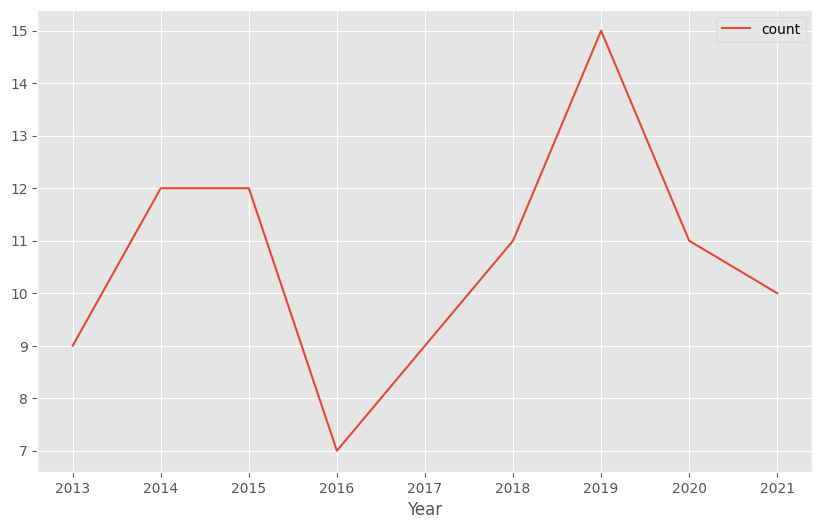

In [21]:
grouped_df = df.groupby('Year').size().to_frame("count").reset_index()

grouped_df.plot(kind='line', x='Year', y='count', figsize=(10,6))

In [22]:
grouped_df

,Year,count
0,2013,9
1,2014,12
2,2015,12
3,2016,7
4,2017,9
5,2018,11
6,2019,15
7,2020,11
8,2021,10


## TFIDF Vectorizer - unigram, bi-gram, tri-gram

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer_1 = TfidfVectorizer(ngram_range=(1,1), norm='l2')
vectorizer_2 = TfidfVectorizer(ngram_range=(2,2), norm='l2')
vectorizer_3 = TfidfVectorizer(ngram_range=(3,3), norm='l2')
vectorizer = TfidfVectorizer(ngram_range=(1,3), norm='l2')

X_1 = vectorizer_1.fit_transform(df['Text_extract'])
X_2 = vectorizer_2.fit_transform(df['Text_extract'])
X_3 = vectorizer_3.fit_transform(df['Text_extract'])
X = vectorizer.fit_transform(df['Text_extract'])

features_1 = vectorizer_1.get_feature_names_out()
features_2 = vectorizer_2.get_feature_names_out()
features_3 = vectorizer_3.get_feature_names_out()
features = vectorizer.get_feature_names_out()

In [24]:
def top_n_tfidf_feats(row, features, top_n=100):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [25]:
def top_tfidf_feats(row, features):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    top_ids = np.argsort(row)[::-1][:]
    top_feats = [(features[i], row[i]) for i in top_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [26]:
def top_feats_in_doc(X, features, row_id):
    ''' Top tfidf features in specific doc (matrix row) '''
    row = np.squeeze(X[row_id].toarray())
    return top_n_tfidf_feats(row, features, top_n=100000)

In [27]:
def top_n_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=100):
    ''' Return the top n features that (in total) are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_n_tfidf_feats(tfidf_means, features, top_n)

In [28]:
def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1):
    ''' Return the top n features that on average are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features)

In [29]:
def top_n_sum_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=100):
    ''' Return the top n features that (in total) are most important amongst documents in rows
        identified by indices in grp_ids. '''
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_sums = np.sum(D, axis=0)
    return top_n_tfidf_feats(tfidf_sums, features, top_n)

In [30]:
def top_sum_feats(X, features, grp_ids=None, min_tfidf=0.1):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_sums = np.sum(D, axis=0)
    return top_tfidf_feats(tfidf_sums, features)

In [31]:
def top_feats_by_year(X, y, features, min_tfidf=0.01, top_n=500000):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class year. '''
    dfs = []
    years = np.unique(y)
    for year in years:
        ids = np.where(y==year)
        feats_df = top_n_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.year = year
        dfs.append(feats_df)
    return dfs

In [32]:
dfs_1 = top_feats_by_year(X_1, df['Year'], features_1)
dfs_2 = top_feats_by_year(X_2, df['Year'], features_2)
dfs_3 = top_feats_by_year(X_3, df['Year'], features_3)
dfs = top_feats_by_year(X, df['Year'], features)

# remove 0 tfidf scores
dfs_1 = [df[df['tfidf']>0] for df in dfs_1]
dfs_2 = [df[df['tfidf']>0] for df in dfs_2]
dfs_3 = [df[df['tfidf']>0] for df in dfs_3]
dfs = [df[df['tfidf']>0] for df in dfs]

# set n-gram as id
dfs_1 = [df.set_index('feature') for df in dfs_1]
dfs_2 = [df.set_index('feature') for df in dfs_2]
dfs_3 = [df.set_index('feature') for df in dfs_3]
dfs = [df.set_index('feature') for df in dfs]

In [33]:
years = range(2013,2022)

In [34]:
ctr = 0

for year in years:
    dfs_1[ctr] = dfs_1[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

In [35]:
ctr = 0

for year in years:
    dfs_2[ctr] = dfs_2[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

In [36]:
ctr = 0

for year in years:
    dfs_3[ctr] = dfs_3[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

In [37]:
ctr = 0

for year in years:
    dfs[ctr] = dfs[ctr].rename(columns={"tfidf": "{}-tfidf".format(year)})
    ctr+=1

### Unigram Ranking of Features - Year Trend

In [38]:
# pd.set_option('display.max_rows', None)

feats_df_1 = pd.concat(dfs_1, axis=1)
feats_df_1_sorted = feats_df_1.assign(Count_NA = lambda x: x.isnull().sum(axis=1)).sort_values('Count_NA', ascending=True).drop('Count_NA', axis=1)

feats_df_1_sorted

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
artifact,0.107744,0.021873,0.049037,0.058773,0.074821,0.042738,0.045894,0.032493,0.066208
compare,0.011922,0.016333,0.011134,0.004573,0.023906,0.009848,0.020752,0.012784,0.013889
investigate,0.003441,0.006910,0.005115,0.002424,0.006887,0.005737,0.004986,0.003860,0.004691
nlp,0.011816,0.014117,0.025994,0.029666,0.026471,0.025590,0.010718,0.004566,0.009828
user,0.011741,0.012236,0.026205,0.010313,0.026354,0.014151,0.005267,0.013745,0.002152
...,...,...,...,...,...,...,...,...,...
btdle,NaN,NaN,NaN,0.022921,NaN,NaN,NaN,NaN,NaN
jianle,NaN,NaN,NaN,0.022921,NaN,NaN,NaN,NaN,NaN
potenza,NaN,NaN,NaN,0.022921,NaN,NaN,NaN,NaN,NaN


In [39]:
req_feats_1 = feats_df_1_sorted[feats_df_1_sorted.index=='requirement']
req_feats_1.columns = [2013,2014,2015,2016,2017,2018,2019,2020,2021]
req_feats_1 = req_feats_1.transpose()
req_feats_1

feature,requirement
2013,0.055217
2014,0.085117
2015,0.101204
2016,0.100406
2017,0.078675
2018,0.123448
2019,0.120094
2020,0.070218
2021,0.076131


In [40]:
des_feats_1 = feats_df_1_sorted[feats_df_1_sorted.index=='design']
des_feats_1

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
design,0.003056,0.022912,0.013939,0.015378,0.029451,0.036564,0.022826,0.039693,0.022622


In [41]:
des_feats_1 = feats_df_1_sorted[feats_df_1_sorted.index=='design']
des_feats_1.columns = [2013,2014,2015,2016,2017,2018,2019,2020,2021]
des_feats_1 = des_feats_1.transpose()
des_feats_1

feature,design
2013,0.003056
2014,0.022912
2015,0.013939
2016,0.015378
2017,0.029451
2018,0.036564
2019,0.022826
2020,0.039693
2021,0.022622


In [42]:
reqdes_feats = pd.concat([req_feats_1,des_feats_1],axis=1)

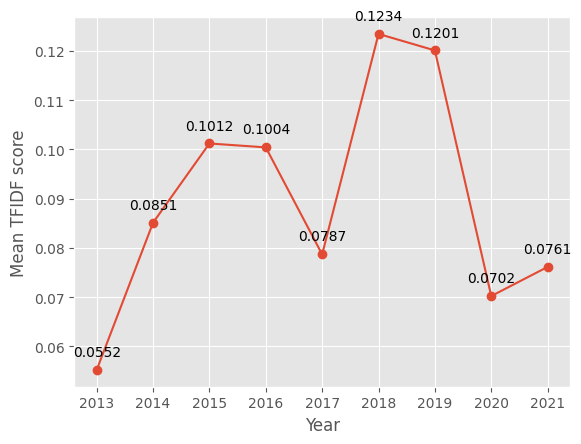

In [43]:
# req_feats_1[req_feats_1.index=='requirement'].transpose().plot(kind='line', figsize=(12,7),style='.-')

import matplotlib.pyplot as plt

plt.plot(req_feats_1,  marker='o')

plt.xlabel('Year')
plt.ylabel('Mean TFIDF score')

for x,y in zip(req_feats_1.index,req_feats_1['requirement']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

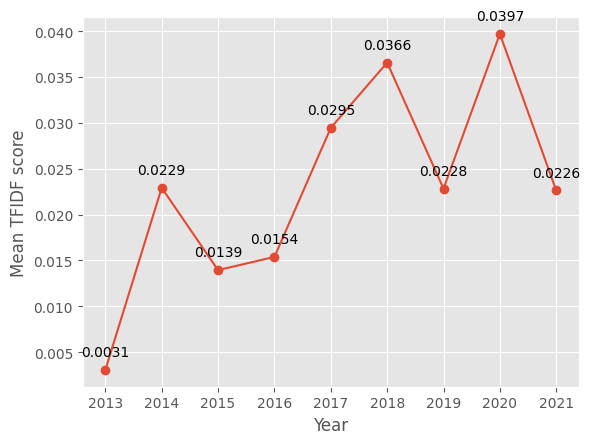

In [44]:
# req_feats_1[req_feats_1.index=='requirement'].transpose().plot(kind='line', figsize=(12,7),style='.-')

import matplotlib.pyplot as plt

plt.plot(des_feats_1,  marker='o')

plt.xlabel('Year')
plt.ylabel('Mean TFIDF score')

for x,y in zip(des_feats_1.index,des_feats_1['design']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

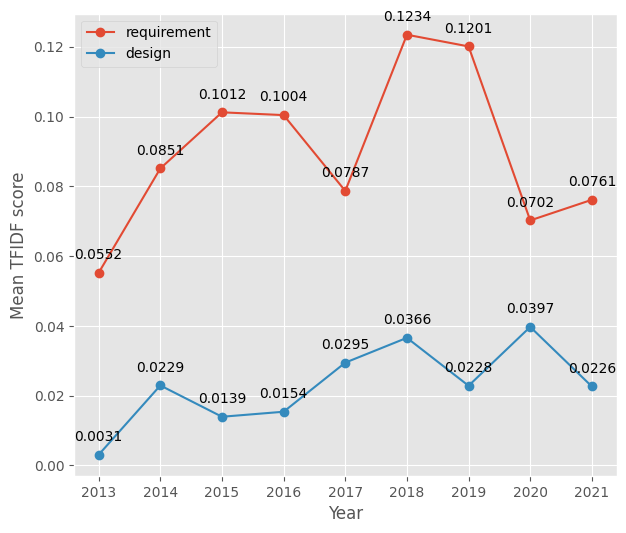

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(reqdes_feats,  marker='o')

plt.xlabel('Year')
plt.ylabel('Mean TFIDF score')

for x,y in zip(des_feats_1.index,des_feats_1['design']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
for x,y in zip(req_feats_1.index,req_feats_1['requirement']):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.legend(['requirement','design'])

<Axes: >

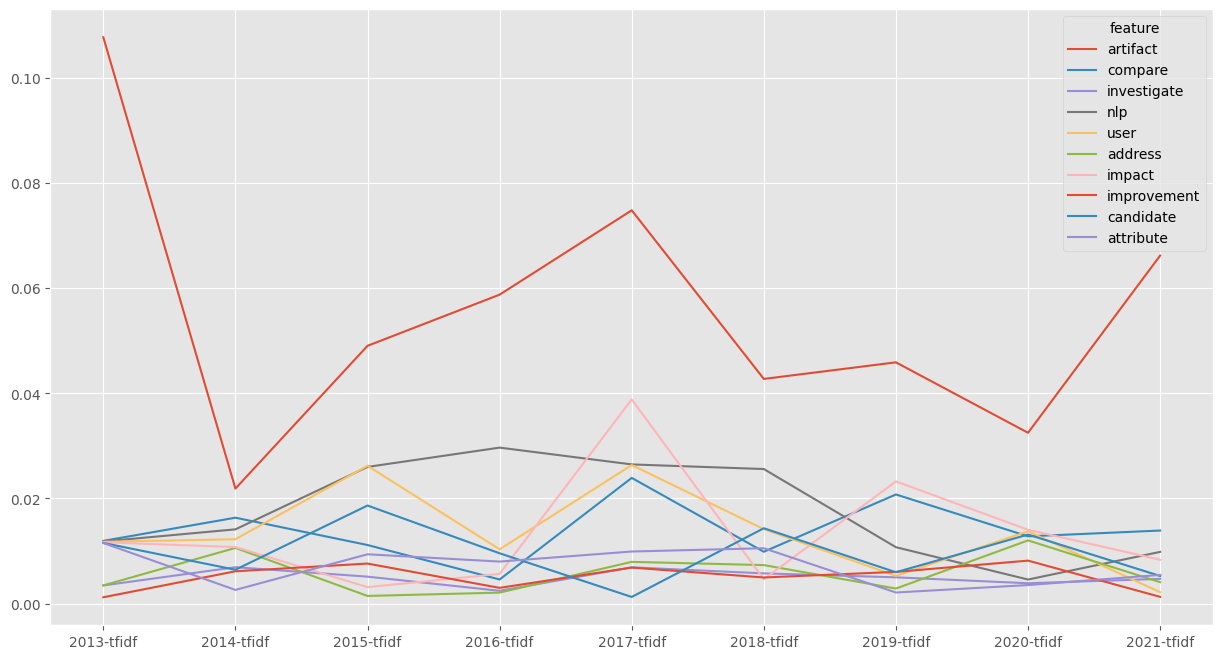

In [46]:
feats_df_1_sorted_sub = feats_df_1_sorted[:10]
# feats_df_1_sorted_sub = feats_df_1_sorted_sub.interpolate(axis=1)
feats_df_1_sorted_sub.transpose().plot(figsize=(15,8))

### Bi-gram Ranking of Features - Year Trend

In [47]:
# pd.set_option('display.max_rows', None)

feats_df_2 = pd.concat(dfs_2, axis=1)
feats_df_2_sorted = feats_df_2.assign(Count_NA = lambda x: x.isnull().sum(axis=1)).sort_values('Count_NA', ascending=True).drop('Count_NA', axis=1)

feats_df_2_sorted

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
result show,0.001426,0.011201,0.003946,0.014538,0.009944,0.009889,0.008766,0.006916,0.004245
requirement source,0.006569,0.003253,0.015530,0.005047,0.004148,0.002665,0.013014,0.005674,0.010920
document source,0.001383,0.000903,0.004078,0.006075,0.001814,0.003155,0.001570,0.000937,0.004858
information retrieval,0.013834,0.015442,0.012610,0.009265,0.020339,0.015842,0.015277,0.011293,0.011551
model vsm,0.002473,0.004881,0.002347,0.001512,0.006385,0.002524,0.004146,0.004278,0.001004
...,...,...,...,...,...,...,...,...,...
function support,NaN,NaN,0.000885,NaN,NaN,NaN,NaN,NaN,NaN
construct relatively,NaN,NaN,0.000885,NaN,NaN,NaN,NaN,NaN,NaN
construct remain,NaN,NaN,0.000885,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

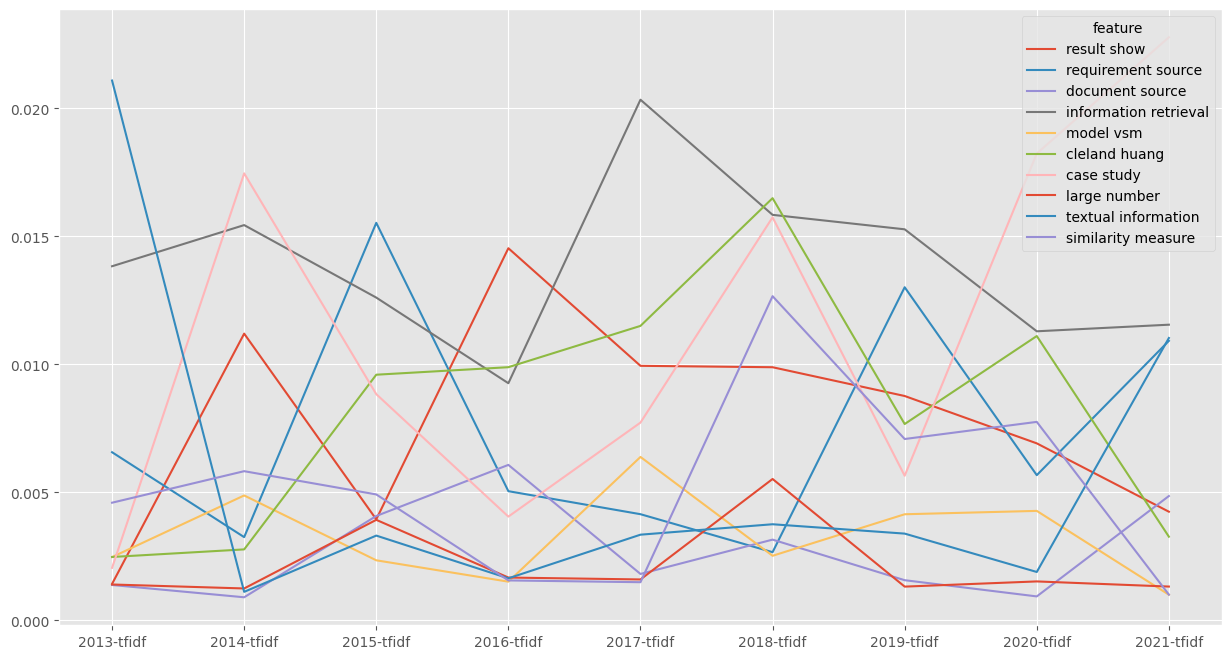

In [48]:
feats_df_2_sorted_sub = feats_df_2_sorted[:10]
feats_df_2_sorted_sub = feats_df_2_sorted_sub.interpolate(axis=1)
feats_df_2_sorted_sub.transpose().plot(figsize=(15,8))

In [49]:
feats_df_2_sorted_sub

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
result show,0.001426,0.011201,0.003946,0.014538,0.009944,0.009889,0.008766,0.006916,0.004245
requirement source,0.006569,0.003253,0.015530,0.005047,0.004148,0.002665,0.013014,0.005674,0.010920
document source,0.001383,0.000903,0.004078,0.006075,0.001814,0.003155,0.001570,0.000937,0.004858
information retrieval,0.013834,0.015442,0.012610,0.009265,0.020339,0.015842,0.015277,0.011293,0.011551
model vsm,0.002473,0.004881,0.002347,0.001512,0.006385,0.002524,0.004146,0.004278,0.001004
cleland huang,0.002477,0.002773,0.009597,0.009891,0.011504,0.016494,0.007671,0.011108,0.003270
case study,0.002053,0.017463,0.008838,0.004054,0.007727,0.015745,0.005650,0.018237,0.022778
large number,0.001403,0.001247,0.003928,0.001674,0.001599,0.005524,0.001320,0.001522,0.001322
textual information,0.021088,0.001115,0.003313,0.001644,0.003348,0.003756,0.003390,0.001891,0.011031


### Tri-gram Ranking of Features - Year Trend

In [50]:
# pd.set_option('display.max_rows', None)

feats_df_3 = pd.concat(dfs_3, axis=1)
feats_df_3_sorted = feats_df_3.assign(Count_NA = lambda x: x.isnull().sum(axis=1)).sort_values('Count_NA', ascending=True).drop('Count_NA', axis=1)

feats_df_3_sorted

,2013-tfidf,2014-tfidf,2015-tfidf,2016-tfidf,2017-tfidf,2018-tfidf,2019-tfidf,2020-tfidf,2021-tfidf
feature,,,,,,,,,
information retrieval technique,0.003051,0.007374,0.004071,0.002547,0.008815,0.000953,0.004223,0.006474,0.003280
requirement source code,0.007009,0.003329,0.019860,0.004879,0.004369,0.001661,0.016565,0.006336,0.009554
document source code,0.001436,0.000976,0.004990,0.005661,0.001787,0.003504,0.001986,0.001096,0.004565
source code test,0.002945,0.005304,0.006888,0.005804,0.006431,0.001163,0.001182,0.001953,0.003643
natural language requirement,NaN,0.000869,0.004359,0.006923,0.001506,0.002335,0.003737,0.002037,0.007905
...,...,...,...,...,...,...,...,...,...
erosion poor motivated,NaN,NaN,0.001194,NaN,NaN,NaN,NaN,NaN,NaN
algorithm apply semantic,NaN,NaN,0.001194,NaN,NaN,NaN,NaN,NaN,NaN
android mobile application,NaN,NaN,0.001194,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

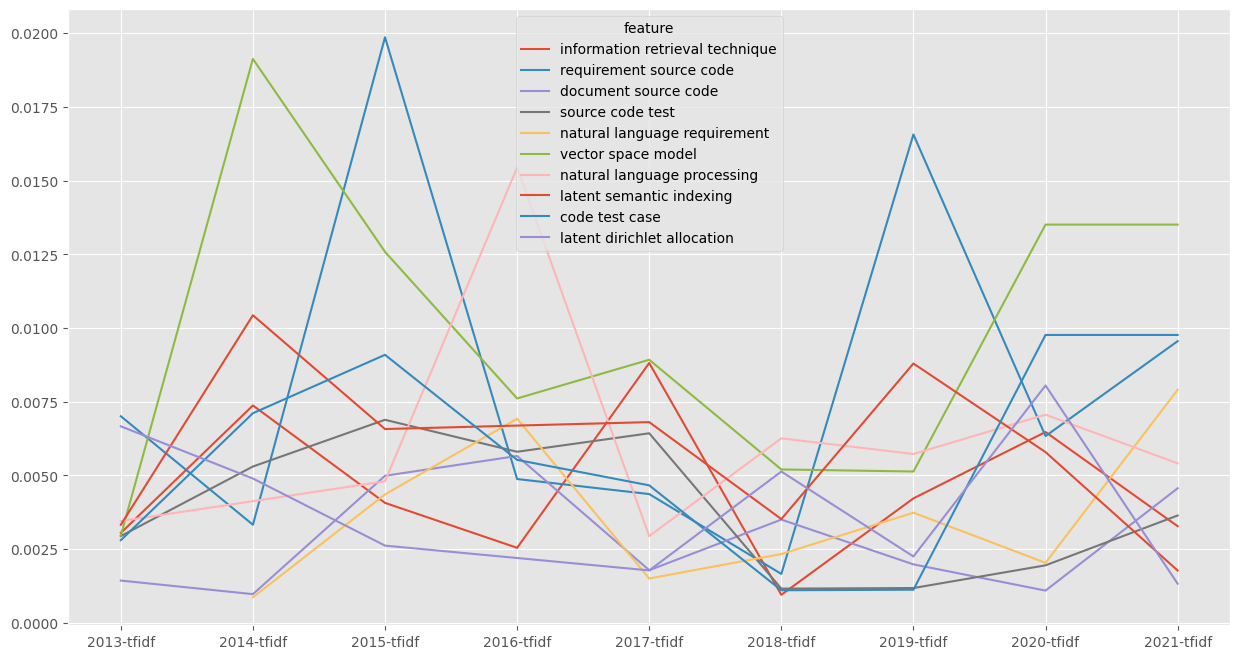

In [51]:
feats_df_3_sorted_sub = feats_df_3_sorted[:10]
feats_df_3_sorted_sub = feats_df_3_sorted_sub.interpolate(axis=1)
feats_df_3_sorted_sub.transpose().plot(figsize=(15,8))

## Embeddings - Dictionary filtering

In [52]:
# from gensim.models.wrappers import FastText

# model = FastText.load_fasttext_format('wiki.en.bin')

In [53]:
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove2word2vec(glove_input_file="glove.6B.50d.txt", word2vec_output_file="glove.w2v.txt")

In [54]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format("C:/Users/biadge/OneDrive - BP/PhD/extraction/SO_vectors_200.bin", binary=True)

In [55]:
unigram_feats = top_sum_feats(X_1, features_1)[:50]['feature'].tolist()
all_feats = top_sum_feats(X, features)[:50]['feature'].tolist()

In [56]:
from sklearn.decomposition import PCA

def display_pca_scatterplot(model, words, ranked=False):
    
    vec_list = []
    
    for w in words:
        try:
            vec_list.append(model[w])
        except:
            continue
    
    word_vectors = np.array(vec_list)
    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    
    x = twodim[:,0]
    y = twodim[:,1]
    
    plt.scatter(x, y)
    
    for i in range(len(x)):
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.show()

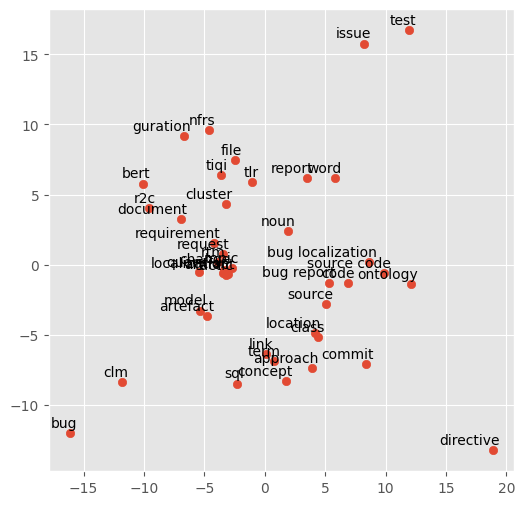

In [57]:
display_pca_scatterplot(model, all_feats)

In [58]:
from sklearn.manifold import TSNE

In [59]:
def display_tsne_scatterplot(model, words, ranked=False):

    labels = []
    tokens = []
    
#     if not ranked:
#         words = words[1:]

    for w in words:
        
        try:
            tokens.append(model[w])
            labels.append(w)
        except:
            continue
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=48)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    if ranked:
        pass
    
    plt.show()

In [60]:
# display_tsne_scatterplot(model,all_feats)

### Nearest points for word vectors input

In [61]:
feats_sum_df = top_sum_feats(X, features)
feats_mean_df = top_mean_feats(X, features)
feats_sum_df = feats_sum_df[feats_sum_df['tfidf']>0]
feats_mean_df = feats_mean_df[feats_mean_df['tfidf']>0]

In [62]:
feats_df = feats_sum_df.merge(feats_mean_df, on='feature', suffixes=('_sum', '_mean'))
feats_df[:10]

,feature,tfidf_sum,tfidf_mean
0,bug,3.581818,0.037311
1,requirement,3.456624,0.036007
2,artefact,3.150786,0.032821
3,link,2.407407,0.025077
4,code,2.282761,0.023779
5,bug report,2.160905,0.022509
6,report,1.764866,0.018384
7,word,1.270349,0.013233
8,model,1.253233,0.013055
9,rtm,1.236949,0.012885


In [63]:
feats_df.to_csv("feats_df.csv", index=False)

In [64]:
def get_cos_sim(x, model, word):
    try:
        res = model.similarity(x, word)
    except:
        res = 0
    return res

In [65]:
get_cos_sim('report', model, 'bug')

0.17773233

In [66]:
def top_n_ranked_terms(df, model, word_input, top_n=20):

    df['similarity'] = df['feature'].apply(lambda x: get_cos_sim(x, model, word_input))
    df['similarity'] = df['similarity'].map(lambda x: '{0:.6f}'.format(x))
    df = df.sort_values('similarity', ascending=False).reset_index(drop=True)
    
    return df[:top_n]

## User input: requirement

In [67]:
ranked_req_feats_df = top_n_ranked_terms(feats_df, model, 'requirement', 21)
ranked_req_feats_df[1:11]

,feature,tfidf_sum,tfidf_mean,similarity
1,hipaa,0.452086,0.004709,0.414685
2,regulation,0.112732,0.001174,0.407030
3,constraint,0.149561,0.001558,0.381385
4,recommendation,0.114736,0.001195,0.376611
5,design,0.237645,0.002475,0.341189
6,feature,0.329262,0.003430,0.340356
7,concept,1.192880,0.012426,0.336251
8,customer,0.102586,0.001069,0.335356
9,architecture,0.426026,0.004438,0.333967
10,case,0.272869,0.002842,0.321802


In [68]:
model.most_similar(positive=['healthcare','requirement'], negative=[], topn=10, restrict_vocab=None)

[('requirements', 0.7149342894554138),
 ('regulatory', 0.6758537292480469),
 ('regulations', 0.6599622964859009),
 ('regulation', 0.6577485799789429),
 ('government', 0.6470068693161011),
 ('telecommunication', 0.6358577609062195),
 ('medical', 0.626889705657959),
 ('ehr', 0.624507486820221),
 ('telecom', 0.6242926120758057),
 ('demands', 0.6223253011703491)]

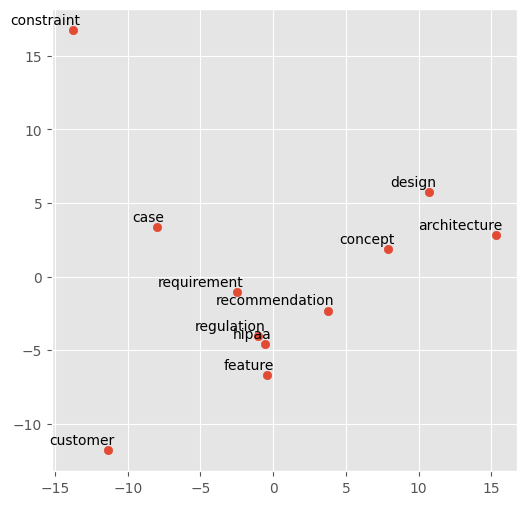

In [69]:
display_pca_scatterplot(model, ranked_req_feats_df['feature'].tolist()[0:11], ranked=True)

In [70]:
# display_tsne_scatterplot(model, ranked_req_feats_df['feature'].tolist()[0:11], ranked=True)

## User input: design

In [71]:
ranked_des_feats_df = top_n_ranked_terms(feats_df, model, 'design', 21)
ranked_des_feats_df[1:11]

,feature,tfidf_sum,tfidf_mean,similarity
1,architectural,0.397169,0.004137,0.699393
2,architecture,0.426026,0.004438,0.589876
3,modularization,0.205741,0.002143,0.518056
4,approach,0.894566,0.009318,0.481808
5,compositional,0.104302,0.001086,0.466911
6,concept,1.192880,0.012426,0.456808
7,uml,0.192009,0.002000,0.449373
8,functional,0.141782,0.001477,0.448855
9,consistency,0.459130,0.004783,0.447875
10,sdlc,0.105824,0.001102,0.433501


In [72]:
model.most_similar(positive=['healthcare','design'], negative=[], topn=10, restrict_vocab=None)

[('architects', 0.7192468047142029),
 ('designing', 0.6962530016899109),
 ('industry', 0.6718052625656128),
 ('medical', 0.6660200357437134),
 ('technological', 0.663608193397522),
 ('economic', 0.6631459593772888),
 ('regulatory', 0.6570987701416016),
 ('industrial', 0.6561939120292664),
 ('avionics', 0.6510811448097229),
 ('logistics', 0.6475102305412292)]

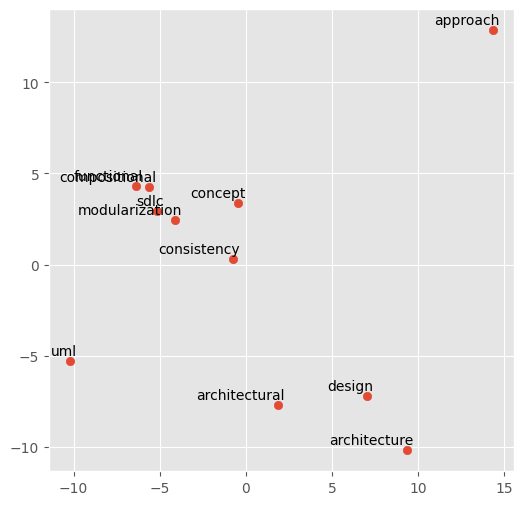

In [73]:
display_pca_scatterplot(model, ranked_des_feats_df['feature'].tolist()[0:11], ranked=True)

In [74]:
# display_tsne_scatterplot(model, ranked_des_feats_df['feature'].tolist()[0:11], ranked=True)

# Time series matrix - requirement

In [75]:
df_meta_req = df.drop(columns=['Text_extract', 'Year', 'File_name'])

In [76]:
df_meta_req_test = df_test.drop(columns=['Text_extract', 'Year', 'File_name'])

In [77]:
def get_term_tfidf(row, term):
    df = top_feats_in_doc(X, features, row)
    
    df = df[df['feature']==term]
    
    if df.empty:
        return None
    
    tfidf_score = df['tfidf'].tolist()[0]
    
    return tfidf_score

In [78]:
from tqdm import tqdm
term_req_tfidf_list = [get_term_tfidf(x, 'requirement') for x in tqdm(range(0,len(df_meta_req)))]

100%|██████████| 96/96 [00:16<00:00,  5.90it/s]


In [79]:
term_req_tfidf_test_list = [get_term_tfidf(x, 'requirement') for x in tqdm(range(0,len(df_meta_req_test)))]

100%|██████████| 24/24 [00:04<00:00,  6.00it/s]


In [80]:
df_meta_req['requirement_tfidf_score'] = term_req_tfidf_list
df_meta_req = df_meta_req.groupby('Timestamp')['requirement_tfidf_score'].mean()
df_meta_req = df_meta_req.reset_index()
df_meta_req = df_meta_req.set_index('Timestamp', drop=True)
df_meta_req[:10]

,requirement_tfidf_score
Timestamp,
2013-02,0.003870
2013-03,0.007832
2013-05,0.031672
2013-07,0.028365
2013-09,0.126495
2013-10,0.127717
2014-01,0.062477
2014-03,0.002374
2014-04,0.056392


In [81]:
df_meta_req_test['requirement_tfidf_score'] = term_req_tfidf_test_list
df_meta_req_test = df_meta_req_test.groupby('Timestamp')['requirement_tfidf_score'].mean()
df_meta_req_test = df_meta_req_test.reset_index()
df_meta_req_test = df_meta_req_test.set_index('Timestamp', drop=True)
df_meta_req_test

,requirement_tfidf_score
Timestamp,
2022-01,0.003870
2022-02,0.007832
2022-03,0.030018
2022-04,0.126495
2022-05,0.127717
2022-06,0.042613
2022-07,0.038616
2022-09,0.064133
2022-10,0.100145


In [82]:
df_meta_req_inter = df_meta_req.interpolate(axis=0)
df_meta_req_inter = df_meta_req_inter.dropna()
df_meta_req_inter.index = df_meta_req_inter.index.astype("datetime64[ns]")
df_meta_req_inter[:10]

,requirement_tfidf_score
Timestamp,
2013-02-01,0.003870
2013-03-01,0.007832
2013-05-01,0.031672
2013-07-01,0.028365
2013-09-01,0.126495
2013-10-01,0.127717
2014-01-01,0.062477
2014-03-01,0.002374
2014-04-01,0.056392


In [83]:
df_meta_req_test_inter = df_meta_req_test.interpolate(axis=0)
df_meta_req_test_inter = df_meta_req_test_inter.dropna()
df_meta_req_test_inter.index = df_meta_req_test_inter.index.astype("datetime64[ns]")
df_meta_req_test_inter

,requirement_tfidf_score
Timestamp,
2022-01-01,0.003870
2022-02-01,0.007832
2022-03-01,0.030018
2022-04-01,0.126495
2022-05-01,0.127717
2022-06-01,0.042613
2022-07-01,0.038616
2022-09-01,0.064133
2022-10-01,0.100145


In [84]:
df_meta_req_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 66 entries, 2013-02-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   requirement_tfidf_score  66 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


In [85]:
df_meta_req_test_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2022-01-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   requirement_tfidf_score  11 non-null     float64
dtypes: float64(1)
memory usage: 176.0 bytes


<Axes: xlabel='Timestamp'>

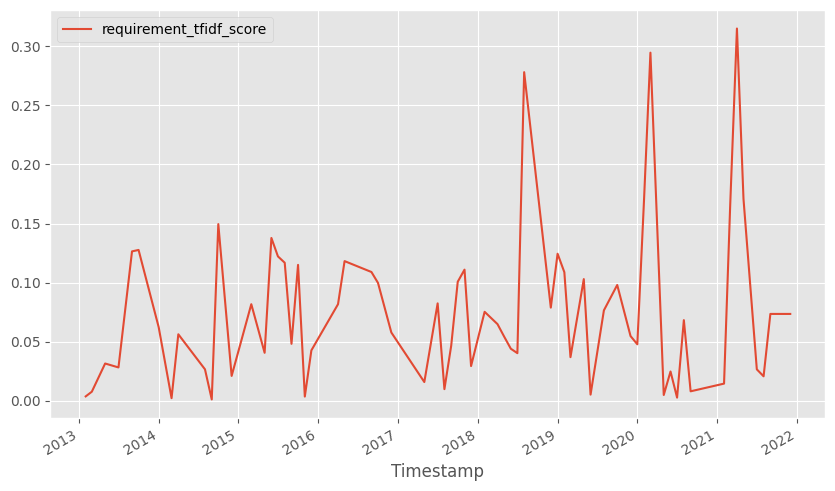

In [86]:
df_meta_req_inter.plot(kind='line', figsize=(10,6))

<Axes: xlabel='Timestamp'>

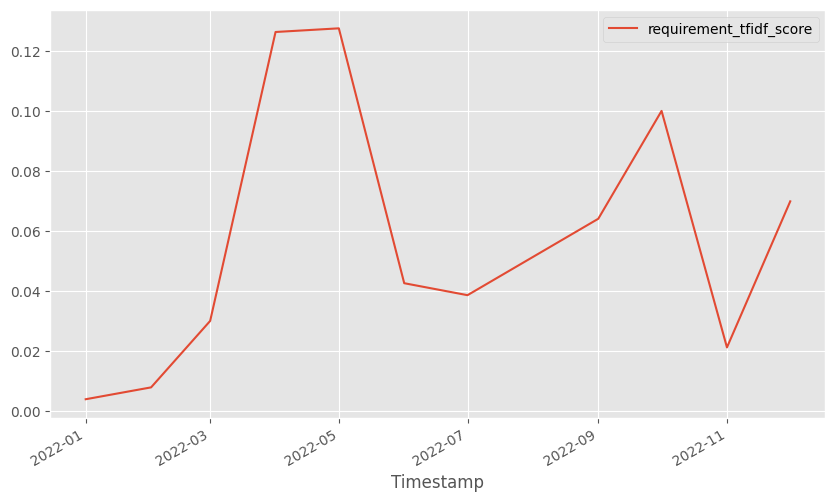

In [87]:
df_meta_req_test_inter.plot(kind='line', figsize=(10,6))

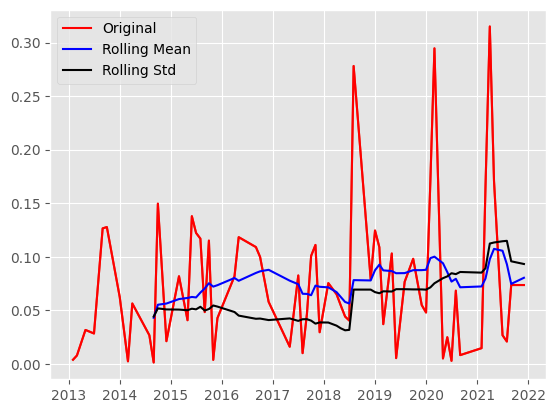

In [88]:
pd.plotting.register_matplotlib_converters()

ts_req = df_meta_req_inter['requirement_tfidf_score']
# plt.figure(figsize=(15,7))
fig = plt.figure(1)
plt.plot(df_meta_req_inter)

rollmean_req = ts_req.rolling(12).mean()
rollstd_req = ts_req.rolling(12).std()

orig_req = plt.plot(ts_req, color='red', label='Original')
mean_req = plt.plot(rollmean_req, color='blue', label='Rolling Mean')
std_req = plt.plot(rollstd_req, color='black', label='Rolling Std')
plt.legend(loc='best')

In [89]:
from statsmodels.tsa.stattools import adfuller

values_req = df_meta_req_inter['requirement_tfidf_score'].values
res_req = adfuller(values_req)

print('Augmented Dickey_fuller Statistic: %f' % res_req[0])
print('p-value: %f' % res_req[1])

print('critical values at different levels:')
for k, v in res_req[4].items():
    print('\t%s: %.3f' % (k, v))

Augmented Dickey_fuller Statistic: -5.462685
p-value: 0.000002
critical values at different levels:
	1%: -3.544
	5%: -2.911
	10%: -2.593


- ADF statistic is lower than the critical values at different levels
- p-value is also lower than 0.05
- we can reject our null hypothesis and conclude that our data is stationary.

In [90]:
df_meta_req_inter_sub = df_meta_req_inter.copy()
df_meta_req_inter_sub.index = pd.DatetimeIndex(df_meta_req_inter_sub.index).to_period('M')

In [91]:
df_meta_req_inter_sub[:10]

,requirement_tfidf_score
Timestamp,
2013-02,0.003870
2013-03,0.007832
2013-05,0.031672
2013-07,0.028365
2013-09,0.126495
2013-10,0.127717
2014-01,0.062477
2014-03,0.002374
2014-04,0.056392


In [92]:
df_meta_req_test_inter_sub = df_meta_req_test_inter.copy()
df_meta_req_test_inter_sub.index = pd.DatetimeIndex(df_meta_req_test_inter_sub.index).to_period('M')

In [93]:
df_meta_req_test_inter_sub

,requirement_tfidf_score
Timestamp,
2022-01,0.003870
2022-02,0.007832
2022-03,0.030018
2022-04,0.126495
2022-05,0.127717
2022-06,0.042613
2022-07,0.038616
2022-09,0.064133
2022-10,0.100145


In [94]:
ts_req_df = df_meta_req_inter_sub.reset_index(drop=True)
ts_req_df[:10]

,requirement_tfidf_score
0,0.003870
1,0.007832
2,0.031672
3,0.028365
4,0.126495
5,0.127717
6,0.062477
7,0.002374
8,0.056392
9,0.041572


In [95]:
ts_req_test_df = df_meta_req_test_inter_sub.reset_index(drop=True)
ts_req_test_df['period'] = [66,67,68,69,70,71,72,74,75,76,77]
ts_req_test_df = ts_req_test_df.set_index('period', drop=True)
ts_req_test_df

,requirement_tfidf_score
period,
66,0.003870
67,0.007832
68,0.030018
69,0.126495
70,0.127717
71,0.042613
72,0.038616
74,0.064133
75,0.100145


In [96]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

ts_req_model = pm.auto_arima(ts_req_df.requirement_tfidf_score, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(ts_req_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-159.468, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-113.849, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-147.527, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-133.838, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-160.136, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-147.352, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-159.245, Time=0.50 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-158.621, Time=0.60 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-160.626, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-141.593, Time=0.19 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-158.631, Time=0.56 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-139.776, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.86 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-163.974, Time=0.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : 

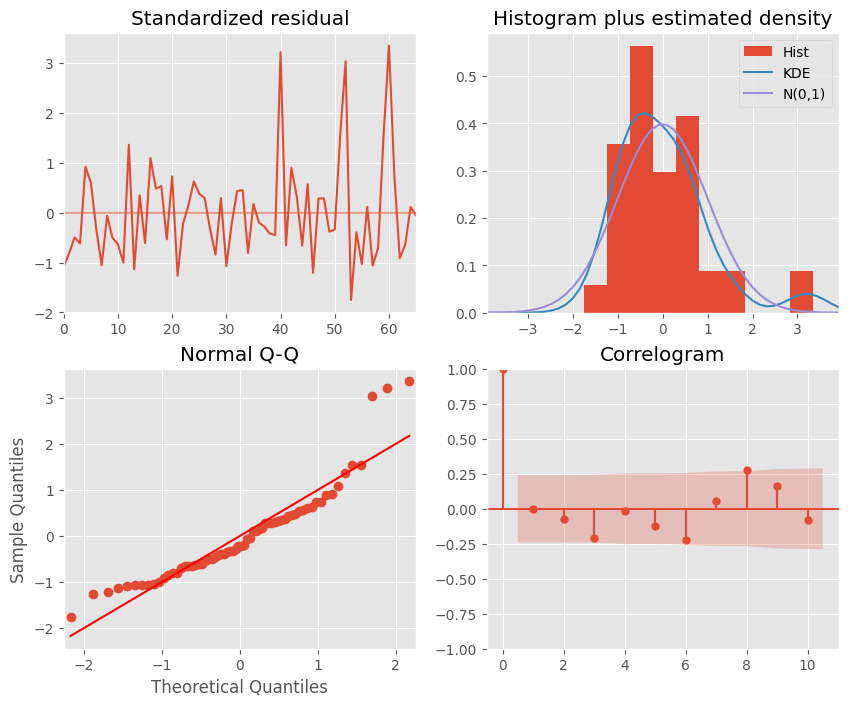

In [97]:
ts_req_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [98]:
ts_req_df

,requirement_tfidf_score
0,0.003870
1,0.007832
2,0.031672
3,0.028365
4,0.126495
...,...
61,0.170850
62,0.026742
63,0.020851
64,0.073604


In [99]:
from datetime import datetime

xticks_req_label = df_meta_req_inter.index.tolist()
to_append_req=(['2022-01-01',
          '2022-02-01',
          '2022-03-01',
          '2022-04-01',
          '2022-05-01',
          '2022-06-01',
          '2022-07-01',
          '2022-08-01',
          '2022-09-01',
          '2022-10-01',
          '2022-11-01',
          '2022-12-01',
          '2023-01-01',
          '2023-02-01',
          '2023-03-01',
          '2023-04-01',
          '2023-05-01',
          '2023-06-01',
          '2023-07-01',
          '2023-08-01',
          '2023-09-01',
          '2023-10-01',
          '2023-11-01',
          '2023-12-01'])

to_append_req_ts = [pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')) for x in to_append_req]

x_ticks_req_label = xticks_req_label+to_append_req_ts

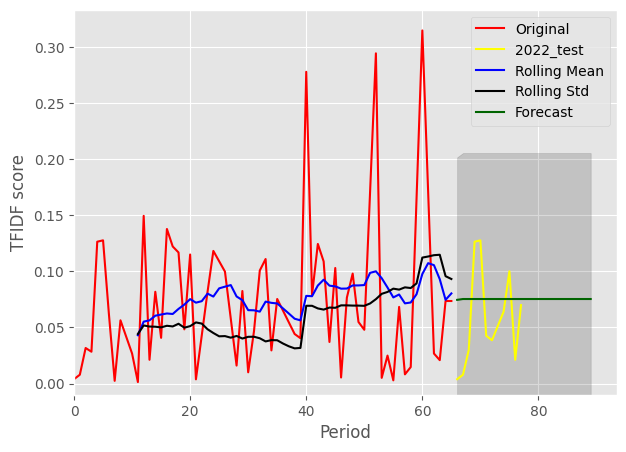

In [100]:
plt.rcParams['figure.figsize'] = [7, 5]

# Forecast
n_periods = 24
fc_req, confint_req = ts_req_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc_req = np.arange(len(ts_req_df.requirement_tfidf_score), len(ts_req_df.requirement_tfidf_score)+n_periods)

# make series for plotting purpose
fc_series_req = pd.Series(fc_req, index=index_of_fc_req)
lower_series_req = pd.Series(confint_req[:, 0], index=index_of_fc_req)
upper_series_req = pd.Series(confint_req[:, 1], index=index_of_fc_req)

# Plot
orig_req = plt.plot(ts_req_df.requirement_tfidf_score, color='red', label='Original')

test_req = plt.plot(ts_req_test_df.requirement_tfidf_score, color='yellow', label='2022_test')

plt.fill_between(lower_series_req.index, 
                 lower_series_req, 
                 upper_series_req, 
                 color='k', alpha=.15)

rollmean_req = ts_req_df.requirement_tfidf_score.rolling(12).mean()
rollstd_req = ts_req_df.requirement_tfidf_score.rolling(12).std()

mean_req = plt.plot(rollmean_req, color='blue', label='Rolling Mean')
std_req = plt.plot(rollstd_req, color='black', label='Rolling Std')
fc_req = plt.plot(fc_series_req, color='darkgreen', label='Forecast')

plt.xlabel("Period")
plt.ylabel("TFIDF score")
plt.legend(loc='best')

plt.ylim(ymin=-0.01)
plt.xlim(xmin=0)

# plt.xticks(np.arange(0, 89, step=1), xticks_label,  rotation='vertical')  # Set label locations.

plt.show()

In [101]:
fc_series_req

66    0.074631
67    0.075376
68    0.075376
69    0.075376
70    0.075376
71    0.075376
72    0.075376
73    0.075376
74    0.075376
75    0.075376
76    0.075376
77    0.075376
78    0.075376
79    0.075376
80    0.075376
81    0.075376
82    0.075376
83    0.075376
84    0.075376
85    0.075376
86    0.075376
87    0.075376
88    0.075376
89    0.075376
dtype: float64

In [135]:
# lower_series_req

In [136]:
# upper_series_req

In [142]:
# predicted: fc_series_req
# actual: ts_req_test_df

In [143]:
ts_req_test_df['predicted'] = fc_series_req
ts_req_test_df

,requirement_tfidf_score,predicted
period,,
66,0.003870,0.074631
67,0.007832,0.075376
68,0.030018,0.075376
69,0.126495,0.075376
70,0.127717,0.075376
71,0.042613,0.075376
72,0.038616,0.075376
74,0.064133,0.075376
75,0.100145,0.075376


In [144]:
req_actual = ts_req_test_df['requirement_tfidf_score']
req_pred = ts_req_test_df['predicted']

In [146]:
import sklearn.metrics as metrics

mae = metrics.mean_absolute_error(req_actual, req_pred)
mse = metrics.mean_squared_error(req_actual, req_pred)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(req_actual,req_pred)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.04111720528205558
MSE: 0.0021010530424297098
RMSE: 0.0458372451444206
R-Squared: -0.1729065911768255


# Time series matrix - design

In [104]:
df_meta_des = df.drop(columns=['Text_extract', 'Year', 'File_name'])

In [105]:
df_meta_des_test = df_test.drop(columns=['Text_extract', 'Year', 'File_name'])

In [106]:
def get_term_tfidf(row, term):
    df = top_feats_in_doc(X, features, row)
    
    df = df[df['feature']==term]
    
    if df.empty:
        return None
    
    tfidf_score = df['tfidf'].tolist()[0]
    
    return tfidf_score

In [107]:
from tqdm import tqdm
term_des_tfidf_list = [get_term_tfidf(x, 'design') for x in tqdm(range(0,len(df_meta_des)))]

100%|██████████| 96/96 [00:16<00:00,  5.90it/s]


In [108]:
term_des_tfidf_test_list = [get_term_tfidf(x, 'design') for x in tqdm(range(0,len(df_meta_des_test)))]

100%|██████████| 24/24 [00:04<00:00,  5.87it/s]


In [109]:
df_meta_des['design_tfidf_score'] = term_des_tfidf_list
df_meta_des = df_meta_des.groupby('Timestamp')['design_tfidf_score'].mean()
df_meta_des = df_meta_des.reset_index()
df_meta_des = df_meta_des.set_index('Timestamp', drop=True)
df_meta_des[:10]

,design_tfidf_score
Timestamp,
2013-02,NaN
2013-03,0.004221
2013-05,0.006693
2013-07,0.006794
2013-09,NaN
2013-10,0.002393
2014-01,0.011445
2014-03,0.001706
2014-04,0.002220


In [110]:
df_meta_des_test['design_tfidf_score'] = term_des_tfidf_test_list
df_meta_des_test = df_meta_des_test.groupby('Timestamp')['design_tfidf_score'].mean()
df_meta_des_test = df_meta_des_test.reset_index()
df_meta_des_test = df_meta_des_test.set_index('Timestamp', drop=True)
df_meta_des_test

,design_tfidf_score
Timestamp,
2022-01,NaN
2022-02,0.004221
2022-03,0.006727
2022-04,NaN
2022-05,0.001530
2022-06,0.008450
2022-07,0.005661
2022-09,0.004306
2022-10,0.077049


In [111]:
df_meta_des_inter = df_meta_des.interpolate(axis=0)
df_meta_des_inter = df_meta_des_inter.dropna()
df_meta_des_inter.index = df_meta_des_inter.index.astype("datetime64[ns]")
df_meta_des_inter[:10]

,design_tfidf_score
Timestamp,
2013-03-01,0.004221
2013-05-01,0.006693
2013-07-01,0.006794
2013-09-01,0.004594
2013-10-01,0.002393
2014-01-01,0.011445
2014-03-01,0.001706
2014-04-01,0.002220
2014-06-01,0.004715


In [112]:
df_meta_des_test_inter = df_meta_des_test.interpolate(axis=0)
df_meta_des_test_inter = df_meta_des_test_inter.dropna()
df_meta_des_test_inter.index = df_meta_des_test_inter.index.astype("datetime64[ns]")
df_meta_des_test_inter

,design_tfidf_score
Timestamp,
2022-02-01,0.004221
2022-03-01,0.006727
2022-04-01,0.004128
2022-05-01,0.001530
2022-06-01,0.008450
2022-07-01,0.005661
2022-09-01,0.004306
2022-10-01,0.077049
2022-11-01,0.053251


In [113]:
df_meta_des_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2013-03-01 to 2021-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   design_tfidf_score  65 non-null     float64
dtypes: float64(1)
memory usage: 1.0 KB


In [114]:
df_meta_des_test_inter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2022-02-01 to 2022-12-01
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   design_tfidf_score  10 non-null     float64
dtypes: float64(1)
memory usage: 160.0 bytes


<Axes: xlabel='Timestamp'>

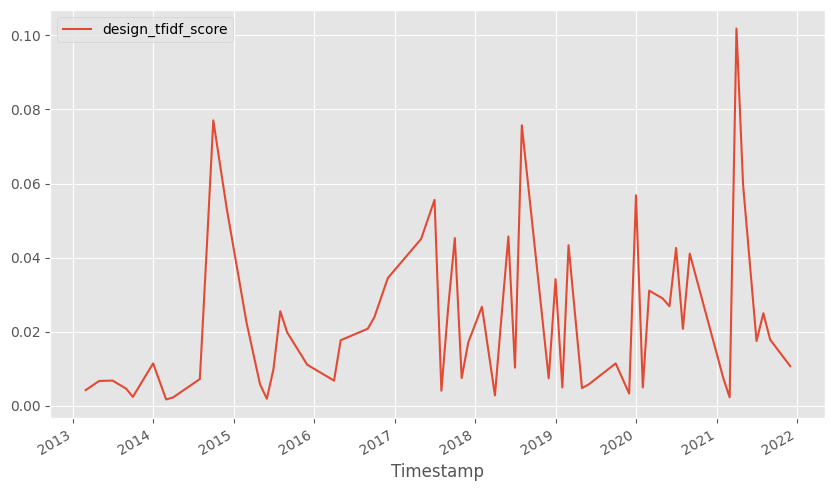

In [115]:
df_meta_des_inter.plot(kind='line', figsize=(10,6))

<Axes: xlabel='Timestamp'>

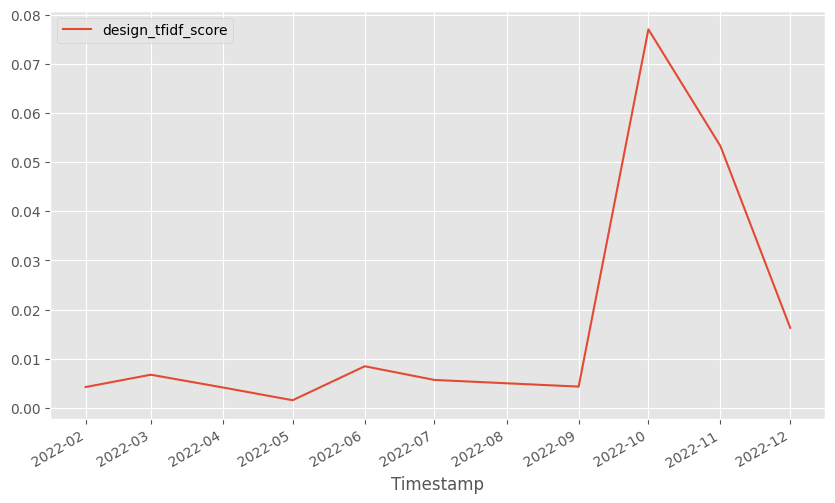

In [116]:
df_meta_des_test_inter.plot(kind='line', figsize=(10,6))

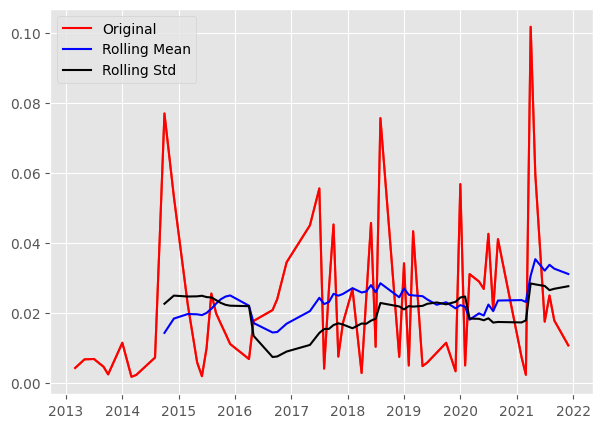

In [117]:
pd.plotting.register_matplotlib_converters()

ts_des = df_meta_des_inter['design_tfidf_score']
# plt.figure(figsize=(15,7))
fig = plt.figure(1)
plt.plot(df_meta_des_inter)

rollmean_des = ts_des.rolling(12).mean()
rollstd_des = ts_des.rolling(12).std()

orig_des = plt.plot(ts_des, color='red', label='Original')
mean_des = plt.plot(rollmean_des, color='blue', label='Rolling Mean')
std_des = plt.plot(rollstd_des, color='black', label='Rolling Std')
plt.legend(loc='best')

In [118]:
from statsmodels.tsa.stattools import adfuller

values_des = df_meta_des_inter['design_tfidf_score'].values
res_des = adfuller(values_des)

print('Augmented Dickey_fuller Statistic: %f' % res_des[0])
print('p-value: %f' % res_des[1])

print('critical values at different levels:')
for k, v in res_des[4].items():
    print('\t%s: %.3f' % (k, v))

Augmented Dickey_fuller Statistic: -6.835599
p-value: 0.000000
critical values at different levels:
	1%: -3.537
	5%: -2.908
	10%: -2.591


- ADF statistic is lower than the critical values at different levels
- p-value is also lower than 0.05
- we can reject our null hypothesis and conclude that our data is stationary.

In [119]:
df_meta_des_inter_sub = df_meta_des_inter.copy()
df_meta_des_inter_sub.index = pd.DatetimeIndex(df_meta_des_inter_sub.index).to_period('M')

In [120]:
df_meta_des_inter_sub[:10]

,design_tfidf_score
Timestamp,
2013-03,0.004221
2013-05,0.006693
2013-07,0.006794
2013-09,0.004594
2013-10,0.002393
2014-01,0.011445
2014-03,0.001706
2014-04,0.002220
2014-06,0.004715


In [121]:
df_meta_des_test_inter_sub = df_meta_des_test_inter.copy()
df_meta_des_test_inter_sub.index = pd.DatetimeIndex(df_meta_des_test_inter_sub.index).to_period('M')

In [122]:
df_meta_des_test_inter_sub

,design_tfidf_score
Timestamp,
2022-02,0.004221
2022-03,0.006727
2022-04,0.004128
2022-05,0.001530
2022-06,0.008450
2022-07,0.005661
2022-09,0.004306
2022-10,0.077049
2022-11,0.053251


In [123]:
ts_des_df = df_meta_des_inter_sub.reset_index(drop=True)
ts_des_df[:10]

,design_tfidf_score
0,0.004221
1,0.006693
2,0.006794
3,0.004594
4,0.002393
5,0.011445
6,0.001706
7,0.002220
8,0.004715
9,0.007209


In [124]:
ts_des_test_df = df_meta_des_test_inter_sub.reset_index(drop=True)
ts_des_test_df['period'] = [67,68,69,70,71,72,74,75,76,77]
ts_des_test_df = ts_des_test_df.set_index('period', drop=True)
ts_des_test_df

,design_tfidf_score
period,
67,0.004221
68,0.006727
69,0.004128
70,0.001530
71,0.008450
72,0.005661
74,0.004306
75,0.077049
76,0.053251


In [125]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

ts_des_model = pm.auto_arima(ts_des_df.design_tfidf_score, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(ts_des_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-306.981, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-265.945, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-292.854, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-280.389, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-306.046, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-305.920, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-285.880, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-297.998, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-310.823, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-312.545, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-313.350, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-312.702, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.689 seconds
                           

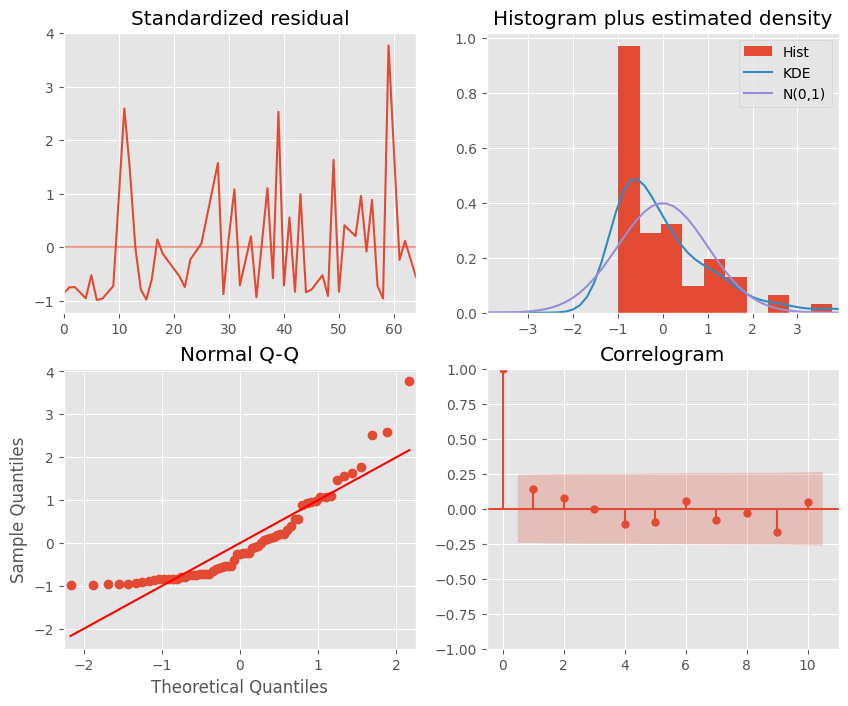

In [126]:
ts_des_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [127]:
ts_des_df

,design_tfidf_score
0,0.004221
1,0.006693
2,0.006794
3,0.004594
4,0.002393
...,...
60,0.059668
61,0.017485
62,0.024973
63,0.017829


In [128]:
from datetime import datetime

xticks_des_label = df_meta_des_inter.index.tolist()
to_append_des=(['2022-01-01',
          '2022-02-01',
          '2022-03-01',
          '2022-04-01',
          '2022-05-01',
          '2022-06-01',
          '2022-07-01',
          '2022-08-01',
          '2022-09-01',
          '2022-10-01',
          '2022-11-01',
          '2022-12-01',
          '2023-01-01',
          '2023-02-01',
          '2023-03-01',
          '2023-04-01',
          '2023-05-01',
          '2023-06-01',
          '2023-07-01',
          '2023-08-01',
          '2023-09-01',
          '2023-10-01',
          '2023-11-01',
          '2023-12-01'])

to_append_des_ts = [pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')) for x in to_append_des]

x_ticks_des_label = xticks_des_label+to_append_des_ts

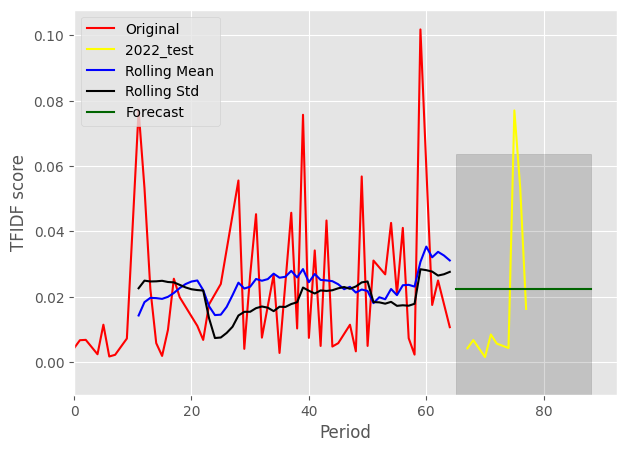

In [129]:
plt.rcParams['figure.figsize'] = [7, 5]

# Forecast
n_periods = 24
fc_des, confint_des = ts_des_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc_des = np.arange(len(ts_des_df.design_tfidf_score), len(ts_des_df.design_tfidf_score)+n_periods)

# make series for plotting purpose
fc_series_des = pd.Series(fc_des, index=index_of_fc_des)
lower_series_des = pd.Series(confint_des[:, 0], index=index_of_fc_des)
upper_series_des = pd.Series(confint_des[:, 1], index=index_of_fc_des)

# Plot
orig_des = plt.plot(ts_des_df.design_tfidf_score, color='red', label='Original')

test_des = plt.plot(ts_des_test_df.design_tfidf_score, color='yellow', label='2022_test')

plt.fill_between(lower_series_des.index, 
                 lower_series_des, 
                 upper_series_des, 
                 color='k', alpha=.15)

rollmean_des = ts_des_df.design_tfidf_score.rolling(12).mean()
rollstd_des = ts_des_df.design_tfidf_score.rolling(12).std()

mean_des = plt.plot(rollmean_des, color='blue', label='Rolling Mean')
std_des = plt.plot(rollstd_des, color='black', label='Rolling Std')
fc_des = plt.plot(fc_series_des, color='darkgreen', label='Forecast')

plt.xlabel("Period")
plt.ylabel("TFIDF score")
plt.legend(loc='upper left')

plt.ylim(ymin=-0.01)
plt.xlim(xmin=0)

# plt.xticks(np.arange(0, 89, step=1), xticks_label,  rotation='vertical')  # Set label locations.

plt.show()

In [130]:
fc_series_des

65    0.022477
66    0.022477
67    0.022477
68    0.022477
69    0.022477
70    0.022477
71    0.022477
72    0.022477
73    0.022477
74    0.022477
75    0.022477
76    0.022477
77    0.022477
78    0.022477
79    0.022477
80    0.022477
81    0.022477
82    0.022477
83    0.022477
84    0.022477
85    0.022477
86    0.022477
87    0.022477
88    0.022477
dtype: float64

In [138]:
# lower_series_des

In [137]:
# upper_series_des

In [147]:
ts_des_test_df['predicted'] = fc_series_des
ts_des_test_df

,design_tfidf_score,predicted
period,,
67,0.004221,0.022477
68,0.006727,0.022477
69,0.004128,0.022477
70,0.001530,0.022477
71,0.008450,0.022477
72,0.005661,0.022477
74,0.004306,0.022477
75,0.077049,0.022477
76,0.053251,0.022477


In [148]:
des_actual = ts_des_test_df['design_tfidf_score']
des_pred = ts_des_test_df['predicted']

In [149]:
import sklearn.metrics as metrics

mae = metrics.mean_absolute_error(des_actual, des_pred)
mse = metrics.mean_squared_error(des_actual, des_pred)
rmse = np.sqrt(mse) 
r2 = metrics.r2_score(des_actual,des_pred)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 0.021386976362078626
MSE: 0.0006130182313416326
RMSE: 0.024759204982018963
R-Squared: -0.031367048605758896
